### Spltting Factors search space exploration according to FLOP threshold

=== Partitioning Strategy Statistics ===
Total configurations tested: 1000
Valid configurations: 500 (50.0%)

FLOPs Statistics:
Max FLOPs across all valid partitions: 102752
Min FLOPs across all valid partitions: 1064
Average FLOPs: 12825 ± 17370

Splitting Factor Statistics:
Spatial - Max: 5, Min: 1, Avg: 3.0
Output - Max: 10, Min: 1, Avg: 5.5
Kernel - Max: 10, Min: 1, Avg: 5.5

Pareto optimal configurations: 19
Pareto optimal points:
     Spatial  Output  Kernel  Max_FLOPs  Total_Partitions
0          5       1       1     102752                 2
109        4       1      10      51376                 4
28         5       3       9      38532                 6
203        3       1       4      27664                 8
119        4       2      10      25688                 8
120        4       3       1      19266                12
138        4       4       9      12844                16
154        4       6       5       9633                24
238        3       4       9       691

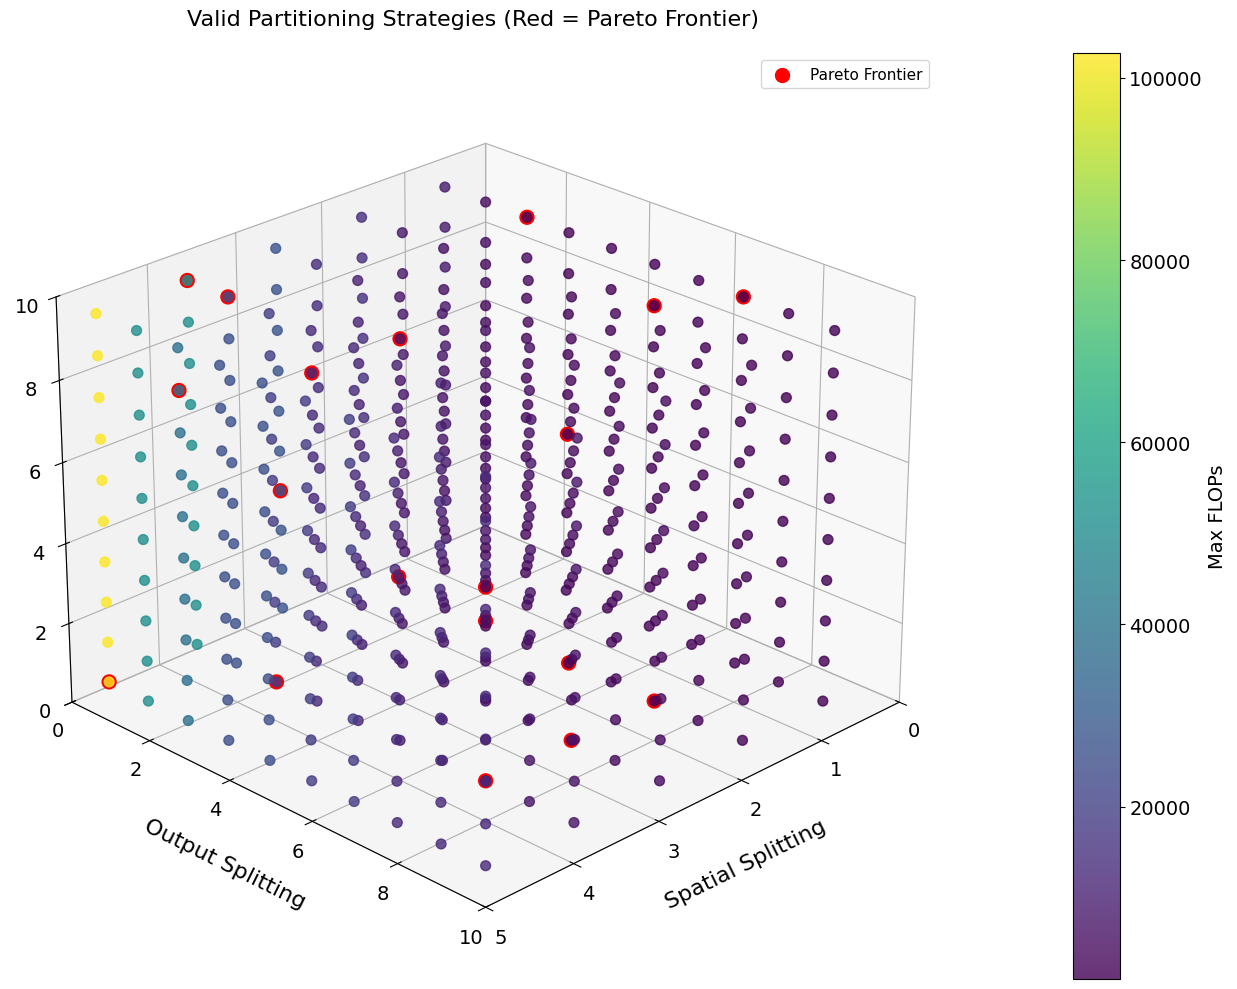

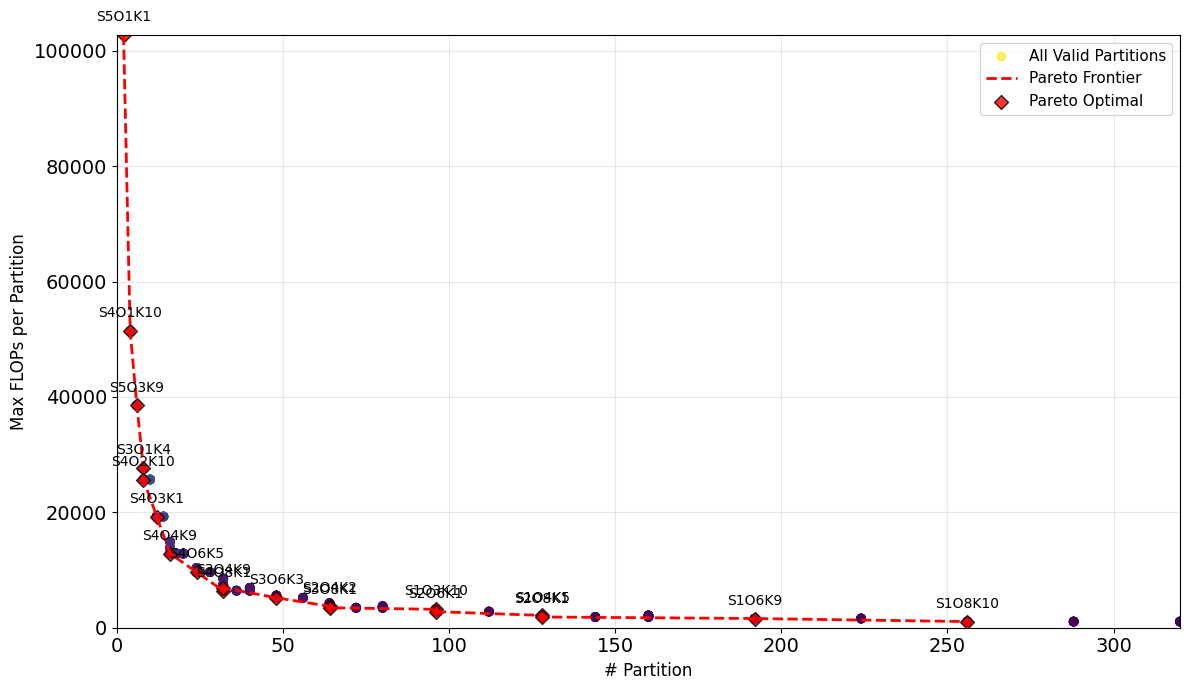

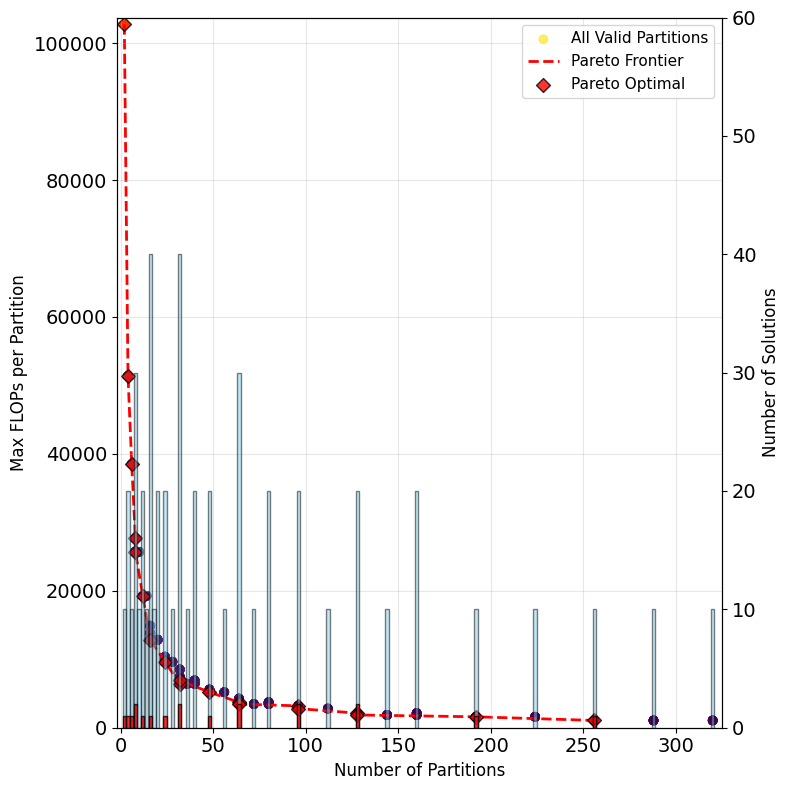


=== Partition Distribution Statistics ===
Most common number of partitions: 16 (40 solutions)
Range of partitions: 2 to 320
Average number of partitions: 68.2
Standard deviation: 76.6

Pareto optimal partition counts:
  2 partitions: 1 solution(s)
  4 partitions: 1 solution(s)
  6 partitions: 1 solution(s)
  8 partitions: 2 solution(s)
  12 partitions: 1 solution(s)
  16 partitions: 1 solution(s)
  24 partitions: 1 solution(s)
  32 partitions: 2 solution(s)
  48 partitions: 1 solution(s)
  64 partitions: 2 solution(s)
  96 partitions: 2 solution(s)
  128 partitions: 2 solution(s)
  192 partitions: 1 solution(s)
  256 partitions: 1 solution(s)


In [57]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Set global matplotlib parameters
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 11

# Load and clean data
df = pd.read_csv("../partition_exploration_results.csv")

# Clean column names (remove trailing commas)
df.columns = df.columns.str.strip(',').str.strip()


# Filter valid configurations
valid_df_first = df[df['Valid'] == True] if 'Valid' in df.columns else df.copy()
valid_df = valid_df_first.copy()

# Reverse spatial splitting values (assuming they go from max to 1, we want 1 to max)
if 'Spatial' in valid_df.columns:
    max_spatial = valid_df['Spatial'].max()
    valid_df['Spatial'] = max_spatial - valid_df['Spatial'] + 1

# Calculate statistics
print("=== Partitioning Strategy Statistics ===")
print(f"Total configurations tested: {len(df)}")
print(f"Valid configurations: {len(valid_df)} ({len(valid_df)/len(df)*100:.1f}%)")
print("\nFLOPs Statistics:")
print(f"Max FLOPs across all valid partitions: {valid_df['Max_FLOPs'].max():.0f}")
print(f"Min FLOPs across all valid partitions: {valid_df['Max_FLOPs'].min():.0f}")
print(f"Average FLOPs: {valid_df['Max_FLOPs'].mean():.0f} ± {valid_df['Max_FLOPs'].std():.0f}")

# Splitting factor statistics
print("\nSplitting Factor Statistics:")
for dim in ['Spatial', 'Output', 'Kernel']:
    print(f"{dim} - Max: {valid_df[dim].max()}, Min: {valid_df[dim].min()}, Avg: {valid_df[dim].mean():.1f}")

# Pareto frontier analysis using actual partition counts
valid_df = valid_df.copy()
valid_df['Total_Partitions'] = valid_df['Partitions']
pareto_front = []
sorted_df = valid_df.sort_values('Total_Partitions')

current_min_flops = float('inf')
for _, row in sorted_df.iterrows():
    if row['Max_FLOPs'] < current_min_flops:
        pareto_front.append(row)
        current_min_flops = row['Max_FLOPs']

print(f"\nPareto optimal configurations: {len(pareto_front)}")
print("Pareto optimal points:")
print(pd.DataFrame(pareto_front)[['Spatial', 'Output', 'Kernel', 'Max_FLOPs', 'Total_Partitions']])

# Create 3D plot with corrected axis limits
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
scatter = ax.scatter(
    valid_df['Spatial'],
    valid_df['Output'],
    valid_df['Kernel'],
    c=valid_df['Max_FLOPs'],
    cmap='viridis',
    s=50,
    alpha=0.8
)

# Set proper axis limits (0 to max for all axes)
ax.set_xlim(0, valid_df['Spatial'].max())
ax.set_ylim(0, valid_df['Output'].max())
ax.set_zlim(0, valid_df['Kernel'].max())

# Highlight Pareto frontier
if len(pareto_front) > 0:
    pareto_df = pd.DataFrame(pareto_front)
    ax.scatter(
        pareto_df['Spatial'],
        pareto_df['Output'],
        pareto_df['Kernel'],
        c='red',
        s=100,
        alpha=1,
        label='Pareto Frontier'
    )
    ax.legend()

# Add colorbar and labels
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Max FLOPs', fontsize=14)
ax.set_xlabel('Spatial Splitting', labelpad=15)
ax.set_ylabel('Output Splitting', labelpad=15)
ax.set_zlabel('Input Splitting', labelpad=15)
ax.set_title('Valid Partitioning Strategies (Red = Pareto Frontier)', pad=20, fontsize=16)
ax.view_init(elev=25, azim=45)
ax.grid(True)
plt.tight_layout()
plt.show()

#########################################################################################################################
# 2D Pareto Frontier Plot (Max FLOPs)
plt.figure(figsize=(12, 7))
plt.scatter(
    valid_df['Total_Partitions'],
    valid_df['Max_FLOPs'],
    c=valid_df['Max_FLOPs'],
    cmap='viridis',
    alpha=0.7,
    label='All Valid Partitions'
)

if len(pareto_front) > 0:
    pf_df = pd.DataFrame(pareto_front).sort_values('Total_Partitions')
    plt.plot(pf_df['Total_Partitions'], pf_df['Max_FLOPs'], 'r--', linewidth=2, label='Pareto Frontier')
    plt.scatter(
        pf_df['Total_Partitions'],
        pf_df['Max_FLOPs'],
        c='red',
        s=50,
        marker='D',
        edgecolor='black',
        label='Pareto Optimal',
        alpha=0.8
    )
    
# Annotate points
for _, row in pf_df.iterrows():
        plt.annotate(
            f"S{row['Spatial']}O{row['Output']}K{row['Kernel']}",
            (row['Total_Partitions'], row['Max_FLOPs']),
            textcoords="offset points",
            xytext=(0,10),
            ha='center'
        )


# Set axis limits from 0 to max
plt.xlim(0, valid_df['Total_Partitions'].max())
plt.ylim(0, valid_df['Max_FLOPs'].max())

plt.xlabel('# Partition', fontsize=12)
plt.ylabel('Max FLOPs per Partition', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#########################################################################################################################
# Combined Pareto Plot with Histogram on the Same Axes
fig, ax1 = plt.subplots(figsize=(8, 8))

# Scatter plot: Pareto frontier with Max FLOPs
scatter = ax1.scatter(
    valid_df['Total_Partitions'],
    valid_df['Max_FLOPs'],
    c=valid_df['Max_FLOPs'],
    cmap='viridis',
    alpha=0.7,
    label='All Valid Partitions'
)

if len(pareto_front) > 0:
    pf_df = pd.DataFrame(pareto_front).sort_values('Total_Partitions')
    ax1.plot(pf_df['Total_Partitions'], pf_df['Max_FLOPs'], 'r--', linewidth=2, label='Pareto Frontier', zorder=1)
    ax1.scatter(
        pf_df['Total_Partitions'],
        pf_df['Max_FLOPs'],
        c='red',
        s=50,
        marker='D',
        edgecolor='black',
        label='Pareto Optimal',
        alpha=0.8,
        zorder=1
    )

ax1.set_xlabel('Number of Partitions', fontsize=12)
ax1.set_ylabel('Max FLOPs per Partition', fontsize=12)
ax1.set_xlim(-2, valid_df['Total_Partitions'].max() + 5)
ax1.set_ylim(0, valid_df['Max_FLOPs'].max() + 1000 )
ax1.grid(True, alpha=0.3)

# Create second y-axis for histogram
ax2 = ax1.twinx()

# Histogram
partition_counts = valid_df['Total_Partitions'].value_counts().sort_index()
ax2.bar(partition_counts.index, partition_counts.values, 
        alpha=0.5, color='skyblue', edgecolor='black', width=1.8, zorder = 2 )

if len(pareto_front) > 0:
    pf_df = pd.DataFrame(pareto_front)
    pareto_partition_counts = pf_df['Total_Partitions'].value_counts().sort_index()
    ax2.bar(pareto_partition_counts.index, pareto_partition_counts.values, 
            alpha=0.8, color='red', edgecolor='black', width=1.8, zorder = 2 )

ax2.set_ylabel('Number of Solutions', fontsize=12)
ax2.set_ylim(0, partition_counts.max() * 1.5)

# Legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Additional statistics for the histogram
print("\n=== Partition Distribution Statistics ===")
print(f"Most common number of partitions: {partition_counts.idxmax()} ({partition_counts.max()} solutions)")
print(f"Range of partitions: {valid_df['Total_Partitions'].min()} to {valid_df['Total_Partitions'].max()}")
print(f"Average number of partitions: {valid_df['Total_Partitions'].mean():.1f}")
print(f"Standard deviation: {valid_df['Total_Partitions'].std():.1f}")

if len(pareto_front) > 0:
    print(f"\nPareto optimal partition counts:")
    for partitions, count in pareto_partition_counts.items():
        print(f"  {partitions} partitions: {count} solution(s)")

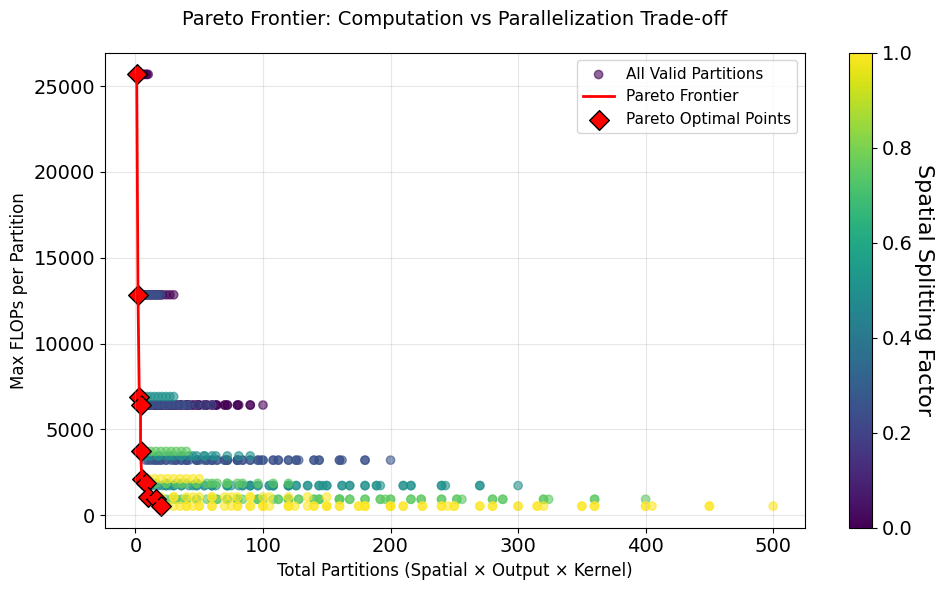

In [ ]:
# HERE is DIFFERENT PROPOSTION OF THE PARETO PLOT

def plot_pareto_frontier(valid_df, pareto_front):
    """
    Plot the Pareto frontier showing the trade-off between total partitions and max FLOPs
    
    Args:
        valid_df: DataFrame containing all valid partitioning configurations
        pareto_front: List of Pareto optimal configurations
    """
    plt.figure(figsize=(10, 6))
    
    # Plot all valid configurations
    plt.scatter(
        valid_df['Total_Partitions'],
        valid_df['Max_FLOPs'],
        c=valid_df['Spatial'],  # Color by spatial splitting factor
        cmap='viridis',
        alpha=0.6,
        label='All Valid Partitions'
    )
    
    # Plot Pareto frontier if it exists
    if len(pareto_front) > 0:
        pf_df = pd.DataFrame(pareto_front)
        # Sort by total partitions for clean line plot
        pf_df = pf_df.sort_values('Total_Partitions')
        
        plt.plot(
            pf_df['Total_Partitions'],
            pf_df['Max_FLOPs'],
            'r-',  # Red line
            linewidth=2,
            label='Pareto Frontier'
        )
        
        plt.scatter(
            pf_df['Total_Partitions'],
            pf_df['Max_FLOPs'],
            c='red',
            s=100,
            marker='D',  # Diamond markers
            edgecolor='black',
            label='Pareto Optimal Points'
        )
    
    # Add labels and title
    plt.xlabel('(Spatial × Output × Kernel)', fontsize=12)
    plt.ylabel('Max FLOPs per Partition', fontsize=12)
    plt.title('Pareto Frontier: Computation vs Parallelization Trade-off', fontsize=14, pad=20)
    
    # Add colorbar
    cbar = plt.colorbar()
    cbar.set_label('Spatial Splitting Factor', rotation=270, labelpad=15)
    
    # Add grid and legend
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Usage (after running your previous code that generates valid_df and pareto_front):
plot_pareto_frontier(valid_df, pareto_front)

In [60]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Set global matplotlib parameters
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 11

# Load and clean data
df = pd.read_csv("../partition_exploration_results.csv")

# Clean column names (remove trailing commas)
df.columns = df.columns.str.strip(',').str.strip()

# Filter valid configurations
valid_df = df[df['Valid'] == True] if 'Valid' in df.columns else df.copy()

# Pareto frontier analysis using actual partition counts
valid_df = valid_df.copy()
valid_df['Total_Partitions'] = valid_df['Partitions']
pareto_front = []
sorted_df = valid_df.sort_values('Total_Partitions')

current_min_flops = float('inf')
for _, row in sorted_df.iterrows():
    if row['Max_FLOPs'] < current_min_flops:
        pareto_front.append(row)
        current_min_flops = row['Max_FLOPs']

print(f"\nPareto optimal configurations: {len(pareto_front)}")
print("Pareto optimal points:")
print(pd.DataFrame(pareto_front)[['Spatial', 'Output', 'Kernel', 'Max_FLOPs', 'Total_Partitions']])

# ===== INTERACTIVE 3D PLOT WITH PLOTLY =====
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Create interactive 3D scatter plot
fig = go.Figure()

# Add all valid partitions
fig.add_trace(go.Scatter3d(
    x=valid_df['Spatial'],
    y=valid_df['Output'],
    z=valid_df['Kernel'],
    mode='markers',
    marker=dict(
        size=6,
        color=valid_df['Max_FLOPs'],
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title="Max FLOPs", x=1.1)
    ),
    text=[f'Spatial: {s}<br>Output: {o}<br>Kernel: {k}<br>Max FLOPs: {f:.0f}<br>Partitions: {p}' 
        for s, o, k, f, p in zip(valid_df['Spatial'], valid_df['Output'], valid_df['Kernel'], 
                                valid_df['Max_FLOPs'], valid_df['Total_Partitions'])],
    hovertemplate='%{text}<extra></extra>',
    name='Valid Partitions'
))

# Add Pareto frontier points
if len(pareto_front) > 0:
    pareto_df = pd.DataFrame(pareto_front)
    fig.add_trace(go.Scatter3d(
        x=pareto_df['Spatial'],
        y=pareto_df['Output'],
        z=pareto_df['Kernel'],
        mode='markers',
        marker=dict(
            size=10,
            color='red',
            symbol='diamond',
            opacity=1,
            line=dict(color='darkred', width=2)
        ),
        text=[f'PARETO OPTIMAL<br>Spatial: {s}<br>Output: {o}<br>Kernel: {k}<br>Max FLOPs: {f:.0f}<br>Partitions: {p}' 
            for s, o, k, f, p in zip(pareto_df['Spatial'], pareto_df['Output'], pareto_df['Kernel'], 
                                    pareto_df['Max_FLOPs'], pareto_df['Total_Partitions'])],
        hovertemplate='%{text}<extra></extra>',
        name='Pareto Frontier'
    ))

# Update layout
fig.update_layout(
    title='Interactive 3D View: Valid Partitioning Strategies',
    scene=dict(
        xaxis_title='Spatial Splitting',
        yaxis_title='Output Splitting',
        zaxis_title='Input Splitting',
        xaxis=dict(range=[0, valid_df['Spatial'].max()]),
        yaxis=dict(range=[0, valid_df['Output'].max()]),
        zaxis=dict(range=[0, valid_df['Kernel'].max()]),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    width=1100,
    height=900,
    showlegend=True
)

# Show the interactive plot
fig.show()

# ===== INTERACTIVE 2D PARETO PLOT WITH PLOTLY =====
fig2 = go.Figure()

# Add all valid partitions
fig2.add_trace(go.Scatter(
    x=valid_df['Total_Partitions'],
    y=valid_df['Max_FLOPs'],
    mode='markers',
    marker=dict(
        size=8,
        color=valid_df['Max_FLOPs'],
        colorscale='Viridis',
        opacity=0.7,
        colorbar=dict(title="Max FLOPs")
    ),
    text=[f'Spatial: {s}, Output: {o}, Kernel: {k}<br>Max FLOPs: {f:.0f}<br>Partitions: {p}' 
          for s, o, k, f, p in zip(valid_df['Spatial'], valid_df['Output'], valid_df['Kernel'], 
                                   valid_df['Max_FLOPs'], valid_df['Total_Partitions'])],
    hovertemplate='%{text}<extra></extra>',
    name='All Valid Partitions'
))

# Add Pareto frontier
if len(pareto_front) > 0:
    pf_df = pd.DataFrame(pareto_front).sort_values('Total_Partitions')
    
    # Add line connecting Pareto points
    fig2.add_trace(go.Scatter(
        x=pf_df['Total_Partitions'],
        y=pf_df['Max_FLOPs'],
        mode='lines',
        line=dict(color='red', width=2, dash='dash'),
        name='Pareto Frontier Line',
        showlegend=False
    ))
    
    # Add Pareto optimal points
    fig2.add_trace(go.Scatter(
        x=pf_df['Total_Partitions'],
        y=pf_df['Max_FLOPs'],
        mode='markers',
        marker=dict(
            size=10,
            color='red',
            symbol='diamond',
            line=dict(color='darkred', width=2)
        ),
        text=[f'PARETO OPTIMAL<br>Spatial: {s}, Output: {o}, Kernel: {k}<br>Max FLOPs: {f:.0f}<br>Partitions: {p}' 
              for s, o, k, f, p in zip(pf_df['Spatial'], pf_df['Output'], pf_df['Kernel'], 
                                       pf_df['Max_FLOPs'], pf_df['Total_Partitions'])],
        hovertemplate='%{text}<extra></extra>',
        name='Pareto Optimal'
    ))

# Update layout for 2D plot
fig2.update_layout(
    title='Interactive Pareto Frontier: Partitions vs Max FLOPs',
    xaxis_title='Number of Partitions',
    yaxis_title='Max FLOPs per Partition',
    xaxis=dict(range=[0, valid_df['Total_Partitions'].max()]),
    yaxis=dict(range=[0, valid_df['Max_FLOPs'].max()]),
    width=900,
    height=600,
    showlegend=True
)

# Show the interactive 2D plot
fig2.show()


Pareto optimal configurations: 19
Pareto optimal points:
     Spatial  Output  Kernel  Max_FLOPs  Total_Partitions
0          1       1       1     102752                 2
109        2       1      10      51376                 4
28         1       3       9      38532                 6
203        3       1       4      27664                 8
119        2       2      10      25688                 8
120        2       3       1      19266                12
138        2       4       9      12844                16
154        2       6       5       9633                24
238        3       4       9       6916                32
170        2       8       1       6422                32
252        3       6       3       5187                48
331        4       4       2       3724                64
270        3       8       1       3458                64
429        5       3      10       3192                96
350        4       6       1       2793                96
434        5  